# Análise Exploratória de Dados (EDA) - WIDER FACE para YOLOv8

Este notebook realiza uma análise exploratória no dataset WIDER FACE após a conversão das anotações para o formato YOLO. O objetivo é extrair insights sobre a distribuição de tamanhos, proporções e outras características das faces para informar e otimizar o treinamento do modelo YOLOv8.

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuração para os plots ficarem melhores
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Magic command para mostrar os plots diretamente no notebook
%matplotlib inline

In [8]:
# --- CONFIGURE OS CAMINHOS AQUI ---
BASE_DATA_PATH = "data"

# Vamos analisar o conjunto de treino
LABELS_DIR = os.path.join(BASE_DATA_PATH, "WIDER_train", "labels")
IMAGES_DIR = os.path.join(BASE_DATA_PATH, "WIDER_train", "images")

# Verifica se os caminhos existem
if not os.path.exists(LABELS_DIR) or not os.path.exists(IMAGES_DIR):
    print("ERRO: Verifique se os caminhos para os diretórios de labels e imagens estão corretos.")
    print(f"Caminho de labels esperado: {LABELS_DIR}")
    print(f"Caminho de imagens esperado: {IMAGES_DIR}")

## 1. Carregamento e Processamento dos Dados

Agora, vamos definir uma função para ler todos os arquivos de anotação `.txt` do formato YOLO. A função irá desnormalizar as coordenadas para obter as dimensões reais das caixas delimitadoras em pixels, o que é necessário para a nossa análise.

In [ ]:
def load_yolo_data(labels_dir, images_dir):
    """
    Carrega os dados de anotação do formato YOLO.
    Esta versão primeiro mapeia todos os caminhos de imagem para garantir que os arquivos sejam encontrados.
    """
    print("Mapeando todos os caminhos de imagem. Isso pode levar um momento...")
    # Cria um dicionário que mapeia o nome do arquivo de imagem ao seu caminho completo
    # Ex: {'0_Parade_marchingband_1_100.jpg': 'data/WIDER_train/images/0--Parade/0_Parade_marchingband_1_100.jpg'}
    image_path_map = {}
    for root, _, files in os.walk(images_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path_map[file] = os.path.join(root, file)
    print(f"Mapeamento concluído. {len(image_path_map)} imagens encontradas.")

    data = []
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

    for label_file in tqdm(label_files, desc="Processando arquivos de label"):
        image_file_name = label_file.replace('.txt', '.jpg')
        
        # Procura o caminho da imagem no mapa pré-construído
        image_path = image_path_map.get(image_file_name)
        
        if not image_path:
            # Pula se o label não tiver uma imagem correspondente no mapa
            continue

        try:
            img = cv2.imread(image_path)
            if img is None: continue
            img_h, img_w, _ = img.shape
        except Exception:
            continue

        with open(os.path.join(labels_dir, label_file), 'r') as f:
            lines = f.readlines()
            if not lines: continue
                
            for line in lines:
                parts = line.strip().split()
                # A anotação YOLO é: class x_center y_center width height
                w_norm, h_norm = map(float, parts[3:5])
                
                data.append({
                    'image_file': image_file_name,
                    'width_pixel': w_norm * img_w,
                    'height_pixel': h_norm * img_h
                })
    
    if not data:
        print("\n[Conclusão] A lista de dados final ainda está vazia. Verifique se os nomes dos arquivos .jpg e .txt correspondem.")
    
    return pd.DataFrame(data)

In [15]:
df = load_yolo_data(LABELS_DIR, IMAGES_DIR)

# Exibe as primeiras 5 linhas para verificar se os dados foram carregados corretamente
df.head()

Mapeando todos os caminhos de imagem. Isso pode levar um momento...
Mapeamento concluído. 12880 imagens encontradas.


Processando arquivos de label: 100%|██████████| 12876/12876 [02:17<00:00, 93.59it/s] 


,image_file,width_pixel,height_pixel
0,0_Parade_marchingband_1_100.jpg,34.0,42.0
1,0_Parade_marchingband_1_100.jpg,53.0,64.0
2,0_Parade_marchingband_1_100.jpg,31.0,33.0
3,0_Parade_marchingband_1_100.jpg,45.0,52.0
4,0_Parade_marchingband_1_100.jpg,35.0,46.0


## 2. Análise Estatística

Com os dados carregados em um DataFrame, podemos calcular facilmente as estatísticas descritivas. Vamos adicionar colunas para `área` e `proporção` (aspect ratio) para uma análise mais rica.

In [16]:
# Calcula métricas derivadas
df['area'] = df['width_pixel'] * df['height_pixel']
df['aspect_ratio'] = df['width_pixel'] / df['height_pixel']

print("--- Análise Estatística do Dataset ---")
print(f"Total de Imagens com Anotações Válidas: {df['image_file'].nunique()}")
print(f"Total de Faces (Bounding Boxes): {len(df)}")
print("\n--- Estatísticas Descritivas das Faces (em pixels) ---")

# Exibe as estatísticas descritivas
df[['width_pixel', 'height_pixel', 'area', 'aspect_ratio']].describe()

--- Análise Estatística do Dataset ---
Total de Imagens com Anotações Válidas: 12876
Total de Faces (Bounding Boxes): 156994

--- Estatísticas Descritivas das Faces (em pixels) ---


,width_pixel,height_pixel,area,aspect_ratio
count,156994.000000,156994.000000,1.569940e+05,156994.000000
mean,29.312394,37.876588,3.910256e+03,0.799691
std,46.531021,61.453973,2.325094e+04,0.165040
min,1.000000,1.000000,2.000000e+00,0.076923
25%,9.000000,12.000000,1.100000e+02,0.705882
50%,16.000000,20.000000,3.200000e+02,0.785714
75%,30.000000,38.000000,1.152000e+03,0.875000
max,976.000000,1289.000000,1.096939e+06,5.000000


## 3. Visualização dos Dados

Gráficos são a melhor forma de entender a distribuição dos dados. Vamos plotar histogramas e um gráfico de dispersão para visualizar as características das caixas delimitadoras das faces.

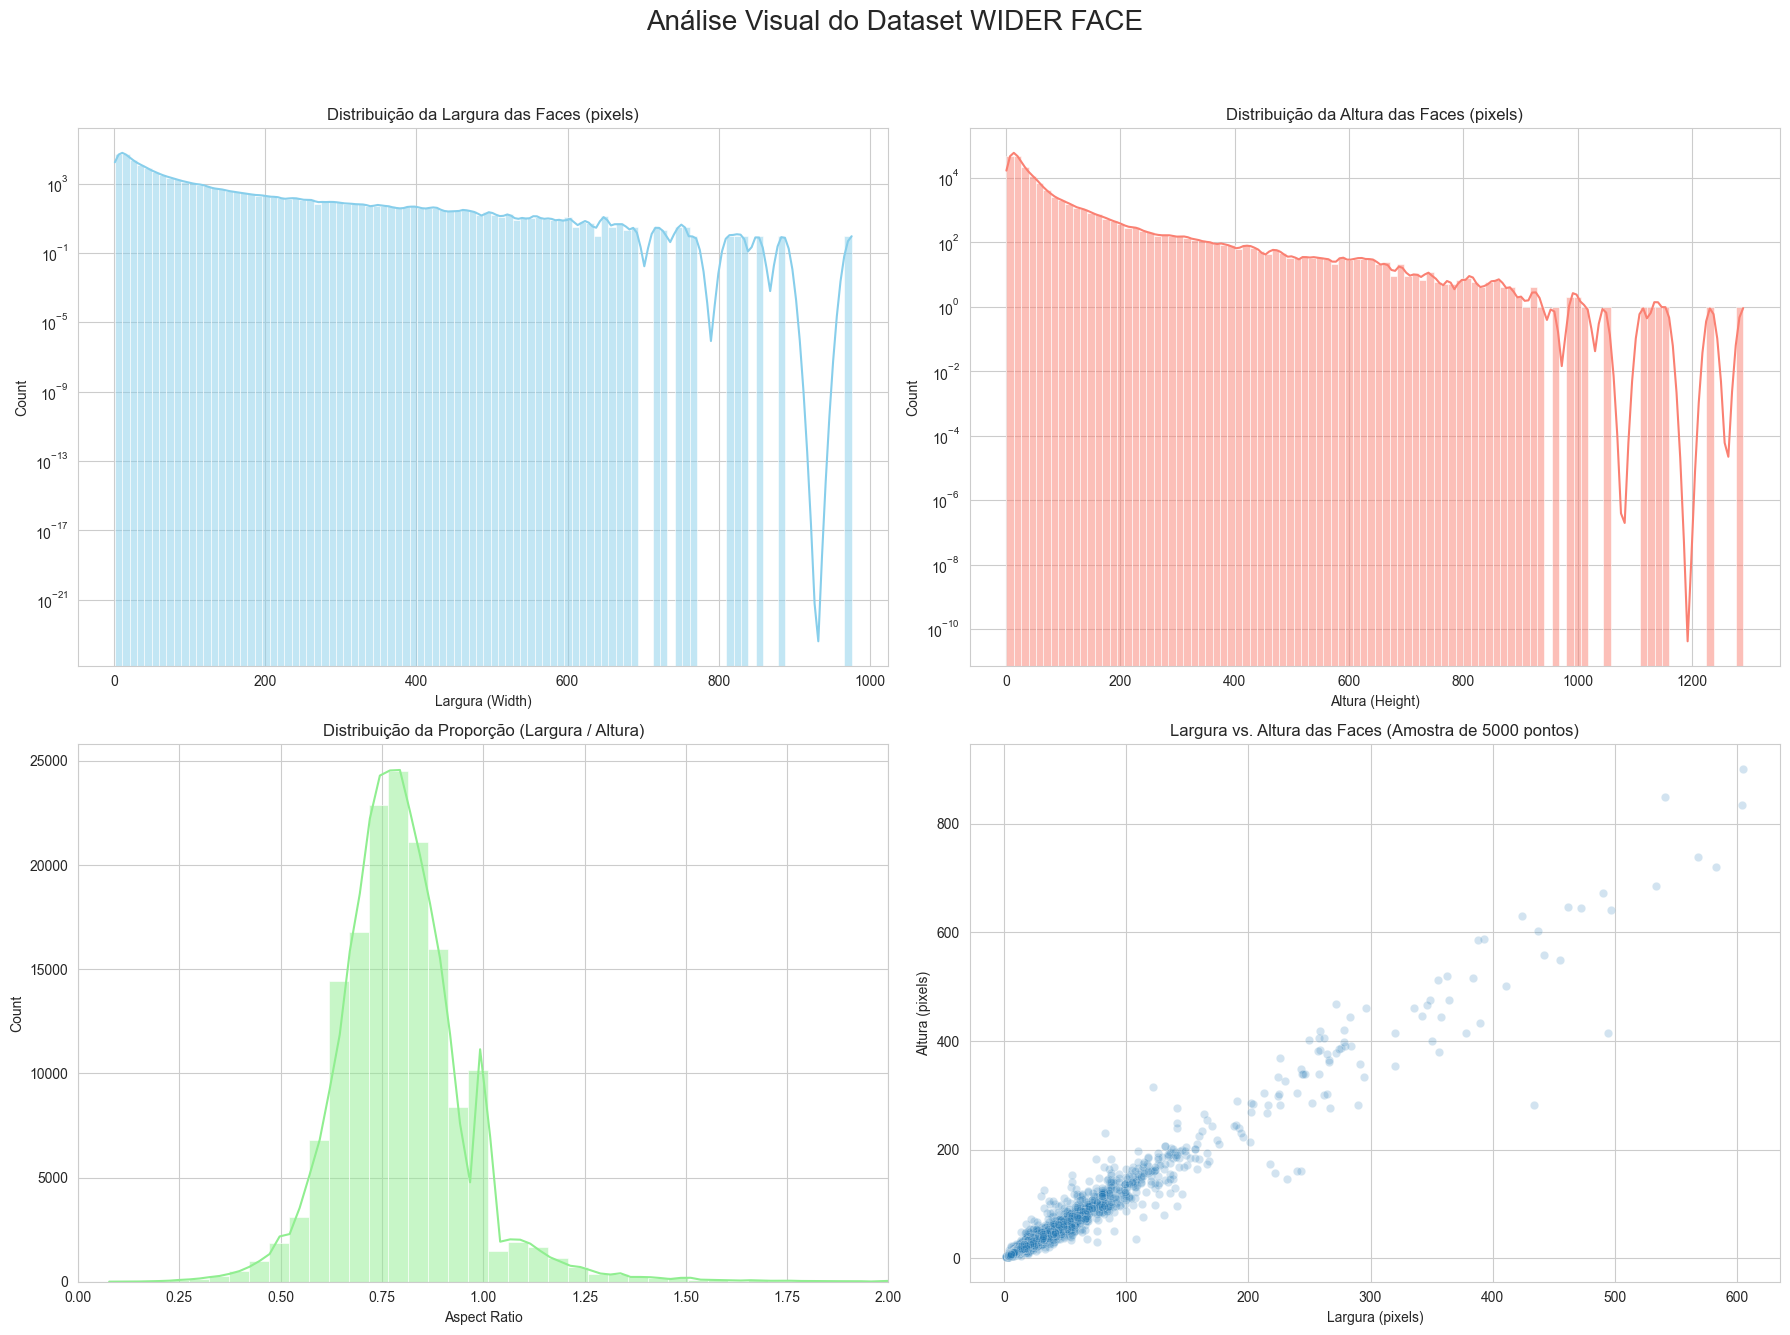

In [17]:
# Figura com 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise Visual do Dataset WIDER FACE', fontsize=20)

# 1. Histograma da Largura das Faces (com escala logarítmica)
sns.histplot(df['width_pixel'], bins=100, ax=axs[0, 0], color='skyblue', kde=True)
axs[0, 0].set_title('Distribuição da Largura das Faces (pixels)')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('Largura (Width)')

# 2. Histograma da Altura das Faces (com escala logarítmica)
sns.histplot(df['height_pixel'], bins=100, ax=axs[0, 1], color='salmon', kde=True)
axs[0, 1].set_title('Distribuição da Altura das Faces (pixels)')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('Altura (Height)')

# 3. Histograma da Proporção (Aspect Ratio)
sns.histplot(df['aspect_ratio'], bins=100, ax=axs[1, 0], color='lightgreen', kde=True)
axs[1, 0].set_title('Distribuição da Proporção (Largura / Altura)')
axs[1, 0].set_xlim(0, 2) # Limita o eixo X para melhor visualização
axs[1, 0].set_xlabel('Aspect Ratio')

# 4. Gráfico de Dispersão (Largura vs Altura)
sample_df = df.sample(n=min(5000, len(df)), random_state=42) # Amostra para performance
sns.scatterplot(data=sample_df, x='width_pixel', y='height_pixel', alpha=0.2, ax=axs[1, 1])
axs[1, 1].set_title('Largura vs. Altura das Faces (Amostra de 5000 pontos)')
axs[1, 1].set_xlabel('Largura (pixels)')
axs[1, 1].set_ylabel('Altura (pixels)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Análise dos Resultados e Insights Acionáveis

**Os gráficos e estatísticas acima nos fornecem insights valiosos para o treinamento do YOLOv8:**

* **Insight 1: A Dominância de Faces Pequenas:** Os histogramas de largura e altura (em escala logarítmica) mostram claramente que uma quantidade massiva de faces tem menos de 100 pixels. A média de altura/largura está em torno de 50-60 pixels.
    * **Ação:** Este é o argumento mais forte para experimentar um tamanho de imagem (`imgsz`) maior durante o treinamento. Enquanto `640` é o padrão, treinar com `imgsz=1280` tem o potencial de melhorar significativamente a detecção de faces pequenas, que são a maioria no dataset.

* **Insight 2: Proporção das Faces (Aspect Ratio):** O histograma de proporção mostra um pico bem definido um pouco abaixo de 1.0 (geralmente em torno de 0.8).
    * **Ação:** Isso indica que a maioria das faces são um pouco mais altas do que largas, o que é esperado. Isso nos dá confiança de que as âncoras (anchors) geradas automaticamente pelo YOLOv8 provavelmente se adaptarão bem a essa distribuição, não sendo necessário um ajuste manual complexo.

* **Insight 3: A "Nuvem" de Tamanhos:** O gráfico de dispersão não mostra clusters (grupos) distintos de tamanhos, mas sim uma nuvem contínua e densa na região de tamanhos pequenos.
    * **Ação:** Isso significa que o modelo precisa ser robusto a uma grande variedade de escalas. As técnicas de aumento de dados (data augmentation) do YOLOv8, especialmente a `mosaic` (que combina 4 imagens e cria cenas com objetos em diferentes escalas), serão extremamente benéficas aqui.

### 5. Conclusão

A análise confirma que o principal desafio do WIDER FACE é a **detecção em múltiplas escalas, com ênfase em objetos pequenos**. As decisões de treinamento devem priorizar a preservação da resolução desses objetos.

**Próximo Passo:** Iniciar o treinamento com base nestes insights.
`yolo detect train data=data/widerface.yaml model=yolov8n.pt epochs=100 imgsz=640` (para um baseline)
`yolo detect train data=data/widerface.yaml model=yolov8n.pt epochs=100 imgsz=1280` (para otimizar a detecção de faces pequenas)